# Training Models on Subsets of Imputed Data
Erica Landreth

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [140]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


In [141]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))

Start with rows that are not missing PCIAT/SII info, and filter out those columns.

Also not super interested in imputing seasons.

In [142]:
data.dropna(subset='sii',inplace=True)
for col in data.columns:
    if 'PCIAT' in col or 'Season' in col:
        data.drop(col,axis=1,inplace=True)

Combined time column:

In [143]:
data["Fitness_Endurance-Time_Sec"].fillna(0)
data["Fitness_Endurance-Time"] = 60*data["Fitness_Endurance-Time_Mins"] + \
    data["Fitness_Endurance-Time_Sec"]
data.drop(columns=["Fitness_Endurance-Time_Mins","Fitness_Endurance-Time_Sec"])

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0,NaN
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0,NaN
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0,453.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0,577.0
5,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,79.6982,35.3804,63.1265,NaN,4.110,40.0,56.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,8,0,NaN,17.139810,52.5,67.2,25.0,60.0,65.0,...,49.3301,20.2645,36.7181,NaN,3.440,41.0,58.0,2.0,0.0,NaN
3954,ff759544,7,1,NaN,13.927006,48.5,46.6,23.0,65.0,75.0,...,42.8185,18.0937,30.0453,NaN,NaN,48.0,67.0,0.0,1.0,NaN
3955,ff8a2de4,13,0,60.0,16.362460,59.5,82.4,NaN,71.0,70.0,...,66.2889,29.7790,52.8320,NaN,3.260,35.0,50.0,1.0,1.0,NaN
3957,ffcd4dbd,11,0,68.0,21.441500,60.0,109.8,NaN,79.0,99.0,...,71.3903,28.7792,54.4630,NaN,2.729,56.0,77.0,0.0,1.0,NaN


In [144]:
# PAQ: usually only child or adult filled in, so make a combined column

data['PAQ'] = data['PAQ_A-PAQ_A_Total'].fillna(data['PAQ_C-PAQ_C_Total'])
data.drop('PAQ_A-PAQ_A_Total',axis=1,inplace=True)
data.drop('PAQ_C-PAQ_C_Total',axis=1,inplace=True)

In [145]:
# fix BIA outliers

# note: reasonable values were determined by looking at histogram plots of the fields,
# for various bin sizes until it was apparent which were outliers
# extension: use outlier detection algorithm instead of hand-crafted cutoffs

data['BIA-BIA_BMC'] = data['BIA-BIA_BMC'].mask(data['BIA-BIA_BMC'] > 20, pd.NA)
data['BIA-BIA_BMR'] = data['BIA-BIA_BMR'].mask(data['BIA-BIA_BMR'] > 2500, pd.NA)
data['BIA-BIA_DEE'] = data['BIA-BIA_DEE'].mask(data['BIA-BIA_DEE'] > 4000, pd.NA)
data['BIA-BIA_ECW'] = data['BIA-BIA_ECW'].mask(data['BIA-BIA_ECW'] > 80, pd.NA)
data['BIA-BIA_FFM'] = data['BIA-BIA_FFM'].mask(data['BIA-BIA_FFM'] > 200, pd.NA)
data['BIA-BIA_FFMI'] = data['BIA-BIA_FFMI'].mask(data['BIA-BIA_FFMI'] > 25, pd.NA)
data['BIA-BIA_FMI'] = data['BIA-BIA_FMI'].mask(data['BIA-BIA_FMI'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] > 100, pd.NA)
data['BIA-BIA_ICW'] = data['BIA-BIA_ICW'].mask(data['BIA-BIA_ICW'] > 100, pd.NA)
data['BIA-BIA_LDM'] = data['BIA-BIA_LDM'].mask(data['BIA-BIA_LDM'] > 50, pd.NA)
data['BIA-BIA_LST'] = data['BIA-BIA_LST'].mask(data['BIA-BIA_LST'] > 150, pd.NA)
data['BIA-BIA_SMM'] = data['BIA-BIA_SMM'].mask(data['BIA-BIA_SMM'] > 100, pd.NA)
data['BIA-BIA_TBW'] = data['BIA-BIA_TBW'].mask(data['BIA-BIA_TBW'] > 125, pd.NA)

In [146]:
data.reset_index(inplace=True,drop=True)
data["idx_orig"] = data.index
data_orig = data.copy()
sii_orig = data.loc[:,'sii']

### Basic Imputation

In [147]:
data.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time,PAQ,idx_orig
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,38.9177,19.5413,32.6909,NaN,NaN,3.0,2.0,NaN,NaN,0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,39.4497,15.4107,27.0552,46.0,64.0,0.0,0.0,NaN,2.340,1
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,38.0,54.0,2.0,0.0,453.0,2.170,2
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,58.9338,26.4798,45.9966,31.0,45.0,0.0,1.0,577.0,2.451,3
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,79.6982,35.3804,63.1265,40.0,56.0,0.0,1.0,NaN,4.110,4


In [148]:
is_missing = data.isna().sum(axis=0).to_frame()
is_missing

,0
id,0
Basic_Demos-Age,0
Basic_Demos-Sex,0
CGAS-CGAS_Score,394
Physical-BMI,209
Physical-Height,206
Physical-Weight,164
Physical-Waist_Circumference,2253
Physical-Diastolic_BP,258
Physical-HeartRate,250


**PAQ: From data dictionary definition, seems like only adult or child field will be filled in. So combine them.**

**Physical: height/weight info probably not as informative as BMI, so use that instead. Also, can fill from BIA BMI if stil missing (and vice versa: fill BIA BMI from Physical BMI).**

In [149]:
data.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time,PAQ,idx_orig
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,38.9177,19.5413,32.6909,NaN,NaN,3.0,2.0,NaN,NaN,0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,39.4497,15.4107,27.0552,46.0,64.0,0.0,0.0,NaN,2.340,1
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,38.0,54.0,2.0,0.0,453.0,2.170,2
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,58.9338,26.4798,45.9966,31.0,45.0,0.0,1.0,577.0,2.451,3
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,79.6982,35.3804,63.1265,40.0,56.0,0.0,1.0,NaN,4.110,4


In [150]:
data['calc-BMI'] = data['Physical-Weight']*0.453592 / (data['Physical-Height']*0.0254)**2
                        #weight kg/height m squared
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['calc-BMI'])
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['BIA-BIA_BMI'])

# and fill the other way around too
data['BIA-BIA_BMI'] = data['BIA-BIA_BMI'].fillna(data['Physical-BMI'])

data.drop('Physical-Height',axis=1,inplace=True)
data.drop('Physical-Weight',axis=1,inplace=True)
data.drop('calc-BMI',axis=1,inplace=True)


**FitnessGram: Zones are derived from values and age. For now, we'll drop the zones entirely, since they contain somewhat redundant info, and they tend to be missing more often than the values themselves.**

**Possible extension: Instead of zones (which tend to take only 2-3 values), create some sort of "age-adjusted" value column, which takes into account age, but is more descriptive than zone**

EDA: visualizing FitnessGram zones vs values, colored by age.

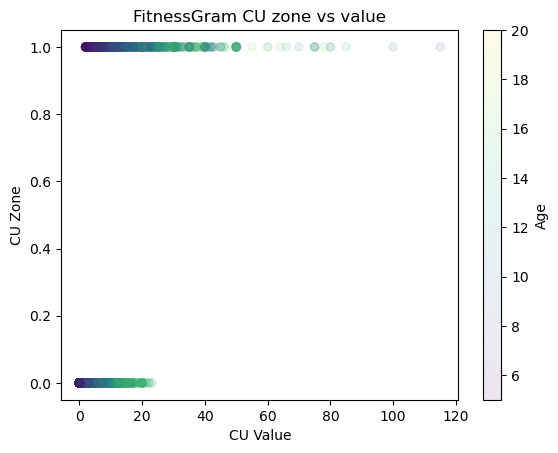

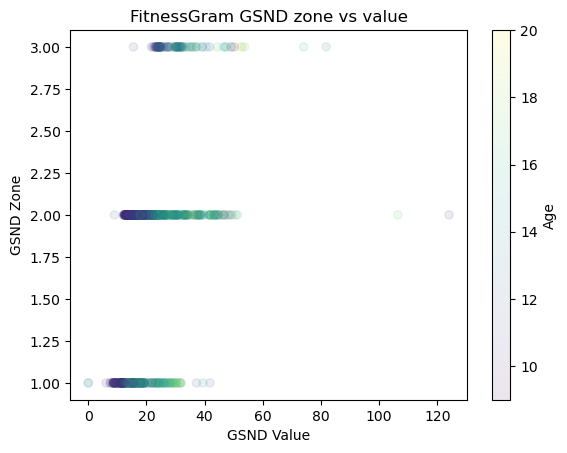

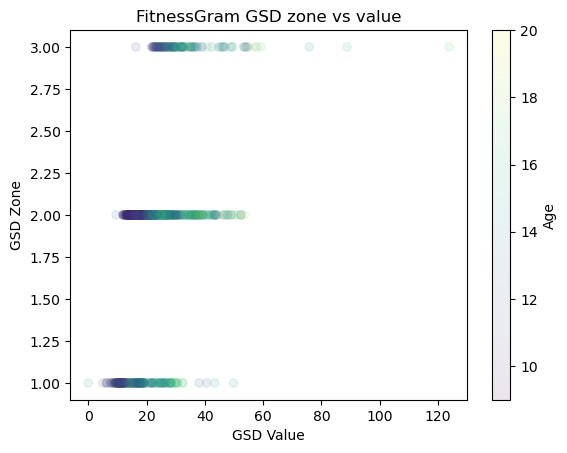

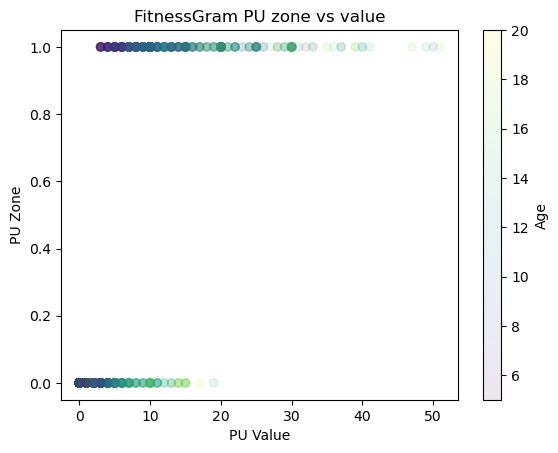

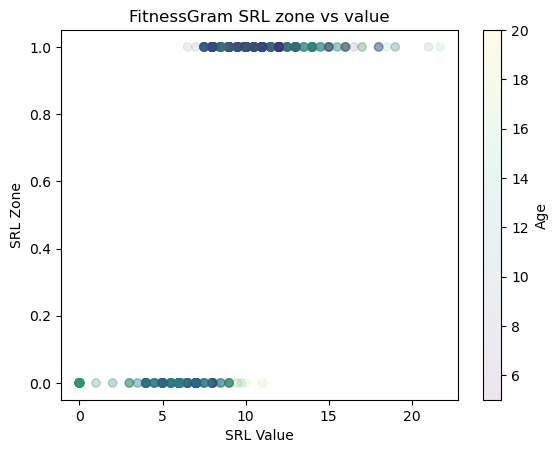

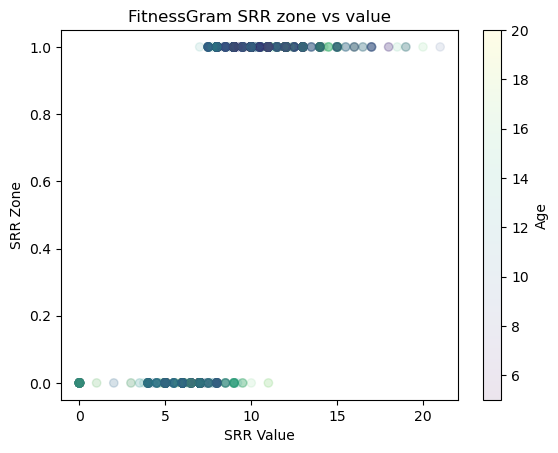

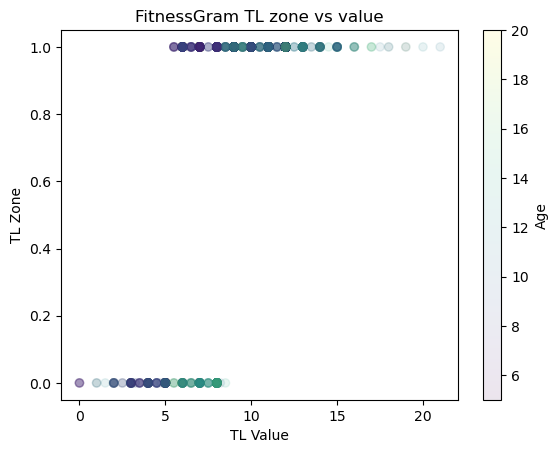

In [152]:
base = ['CU','GSND','GSD','PU','SRL','SRR','TL']
for b in base:
    f1 = f'FGC-FGC_{b}'
    f2 = f1+'_Zone'
    fig,ax = plt.subplots(1,1)
    s = ax.scatter(f1,f2,c='Basic_Demos-Age',data=data,alpha=0.1)
    ax.set_xlabel(f'{b} Value')
    ax.set_ylabel(f'{b} Zone')
    ax.set_title(f'FitnessGram {b} zone vs value')
    c = plt.colorbar(s, ax=ax)
    c.set_label('Age')
    plt.show()

In [14]:
data.drop([col for col in data.columns if '_Zone' in col],axis=1,inplace=True)

Checking in: what does data look like, and what are we still missing?

In [15]:
data

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,...,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time,PAQ,idx_orig
0,00008ff9,5,0,51.0,16.877316,NaN,NaN,NaN,NaN,NaN,...,38.9177,19.5413,32.6909,NaN,NaN,3.0,2.0,NaN,NaN,0
1,000fd460,9,0,NaN,14.035590,22.0,75.0,70.0,122.0,NaN,...,39.4497,15.4107,27.0552,46.0,64.0,0.0,0.0,NaN,2.340,1
2,00105258,10,1,71.0,16.648696,NaN,65.0,94.0,117.0,5.0,...,NaN,NaN,NaN,38.0,54.0,2.0,0.0,453.0,2.170,2
3,00115b9f,9,0,71.0,18.292347,NaN,60.0,97.0,117.0,6.0,...,58.9338,26.4798,45.9966,31.0,45.0,0.0,1.0,577.0,2.451,3
4,001f3379,13,1,50.0,22.279952,NaN,60.0,73.0,102.0,NaN,...,79.6982,35.3804,63.1265,40.0,56.0,0.0,1.0,NaN,4.110,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,8,0,NaN,17.139810,25.0,60.0,65.0,112.0,NaN,...,49.3301,20.2645,36.7181,41.0,58.0,2.0,0.0,NaN,3.440,2731
2732,ff759544,7,1,NaN,13.927006,23.0,65.0,75.0,105.0,NaN,...,42.8185,18.0937,30.0453,48.0,67.0,0.0,1.0,NaN,NaN,2732
2733,ff8a2de4,13,0,60.0,16.362460,NaN,71.0,70.0,104.0,NaN,...,66.2889,29.7790,52.8320,35.0,50.0,1.0,1.0,NaN,3.260,2733
2734,ffcd4dbd,11,0,68.0,21.441500,NaN,79.0,99.0,116.0,NaN,...,71.3903,28.7792,54.4630,56.0,77.0,0.0,1.0,NaN,2.729,2734


In [16]:
is_missing = data.isna().mean(axis=0).to_frame().sort_values(by=0,ascending=False)
is_missing
# below table: proportion of data missing each field

,0
Physical-Waist_Circumference,0.823465
Fitness_Endurance-Time,0.734284
Fitness_Endurance-Time_Mins,0.733918
Fitness_Endurance-Time_Sec,0.733918
Fitness_Endurance-Max_Stage,0.732822
FGC-FGC_GSD,0.681652
FGC-FGC_GSND,0.681287
BIA-BIA_Fat,0.355629
BIA-BIA_FMI,0.348684
BIA-BIA_LST,0.347222


We'll choose to drop any fields that are missing at least half the time.

In [17]:
data.drop(list(is_missing[is_missing > 0.5].dropna().index),axis=1,inplace=True)

Store "basic imputation" level data:

In [18]:
data.reset_index(inplace=True,drop=True)
data_basic_impute= data.copy()

### KNN Imputation

Since the holes vary so much from record to record, going to brute force it for now and loop through all columns for all records.

Extension: think about a more clever way to do this

In [19]:
# define column groups

cols = list(data_orig.columns)
col_groups = {}

tests = ["Basic_Demos","CGAS","Physical","Fitness_Endurance","FGC","BIA","PAQ","SDS","PreInt"]
for test in tests:
    col_groups[test] = [col for col in data.columns if test in col]
col_groups["PAQ"] = ["PAQ"]

print(col_groups)

feat_cols = list(itertools.chain.from_iterable(col_groups.values()))
print(feat_cols)

{'Basic_Demos': ['Basic_Demos-Age', 'Basic_Demos-Sex'], 'CGAS': ['CGAS-CGAS_Score'], 'Physical': ['Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP'], 'Fitness_Endurance': [], 'FGC': ['FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL'], 'BIA': ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'], 'PAQ': ['PAQ'], 'SDS': ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], 'PreInt': ['PreInt_EduHx-computerinternet_hoursday']}
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_EC

In [20]:
N = 3

for idx in range(data.shape[0]):
    item = data.loc[[idx]]
    sii = item.sii.values[0]
    item = item[feat_cols]

    is_missing = item.isnull().any()
    missing_cols = is_missing[is_missing].index.tolist()
    feat_data = item.dropna(axis=1)

    for col in missing_cols:
        use_me = [col for col in feat_data.columns if col in data_basic_impute.columns] + [col]
        feat_ref = data_basic_impute.loc[:, use_me].dropna()
        if feat_ref.shape[0] == 0:
            print("No data")
        if feat_ref.shape[0] < 5:
            print('!!!')
            continue
        x = feat_ref[list(feat_data.columns)]
        y = feat_ref[col]
        if col == 'PAQ':
            knn = KNeighborsRegressor(n_neighbors=N)
        elif 'categorical' in data_dict.Type[data_dict.Field == col].values[0]:
            knn = KNeighborsClassifier(n_neighbors=N)
        else:
            knn = KNeighborsRegressor(n_neighbors=N)
        knn.fit(x,y.values)
        y_fill = knn.predict(feat_data)
        data.loc[idx,col] = y_fill


Double check that everything was imputed (i.e. no more missing values)

In [21]:
data.shape == data.dropna().shape

True

In [22]:
data_knn_impute = data.copy()
data_knn_impute

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_PU,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ,idx_orig
0,00008ff9,5,0,51.000000,16.877316,74.666667,75.333333,128.333333,0.000000,0.0,...,8.89536,38.9177,19.5413,32.690900,38.333333,54.333333,3.0,2.0,1.943333,0
1,000fd460,9,0,68.333333,14.035590,75.000000,70.000000,122.000000,3.000000,5.0,...,14.97400,39.4497,15.4107,27.055200,46.000000,64.000000,0.0,0.0,2.340000,1
2,00105258,10,1,71.000000,16.648696,65.000000,94.000000,117.000000,20.000000,7.0,...,13.98280,50.8585,23.5805,40.767467,38.000000,54.000000,2.0,0.0,2.170000,2
3,00115b9f,9,0,71.000000,18.292347,60.000000,97.000000,117.000000,18.000000,5.0,...,16.77900,58.9338,26.4798,45.996600,31.000000,45.000000,0.0,1.0,2.451000,3
4,001f3379,13,1,50.000000,22.279952,60.000000,73.000000,102.000000,12.000000,6.0,...,20.90200,79.6982,35.3804,63.126500,40.000000,56.000000,0.0,1.0,4.110000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,8,0,62.666667,17.139810,60.000000,65.000000,112.000000,0.000000,0.0,...,15.81500,49.3301,20.2645,36.718100,41.000000,58.000000,2.0,0.0,3.440000,2731
2732,ff759544,7,1,68.333333,13.927006,65.000000,75.000000,105.000000,0.000000,0.0,...,15.14000,42.8185,18.0937,30.045300,48.000000,67.000000,0.0,1.0,2.633333,2732
2733,ff8a2de4,13,0,60.000000,16.362460,71.000000,70.000000,104.000000,16.000000,10.0,...,17.97970,66.2889,29.7790,52.832000,35.000000,50.000000,1.0,1.0,3.260000,2733
2734,ffcd4dbd,11,0,68.000000,21.441500,79.000000,99.000000,116.000000,15.000000,0.0,...,21.34030,71.3903,28.7792,54.463000,56.000000,77.000000,0.0,1.0,2.729000,2734


# Split into train, test, val

First, define shuffled indices for train, validation, and test data that we'll use to train each model.

In [23]:
# train/val/test split
split = (0.6, 0.2, 0.2)

# original dataset index
idx = np.array(data_orig.index)

# set seed
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle index
idx_shuffled = np.random.permutation(idx)

# create random splits
splits = np.multiply(len(idx), split).astype(int)
idx_train, idx_val, idx_test = np.split(idx_shuffled, [splits[0], splits[0]+splits[1]])

In [24]:
def get_data( feat_cols, X, y=sii_orig, idx_train=idx_train, \
             idx_val=idx_val, idx_test=idx_test, verbose=True):
    
    # if feat_cols is None:
    # this means we keep data as is and split, regarless of empties
    
    if feat_cols is not None:
        X = X[feat_cols + ["idx_orig"]].dropna()
        idx_orig = X.idx_orig
        X = X[feat_cols]
    else:
        idx_orig = X.idx_orig

    idx_train = np.intersect1d(idx_train, idx_orig)
    idx_val = np.intersect1d(idx_val, idx_orig)
    idx_test = np.intersect1d(idx_test, idx_orig)

    X_train = X[idx_orig.isin(idx_train)]
    X_val = X[idx_orig.isin(idx_val)]
    X_test = X[idx_orig.isin(idx_test)]

    y_train = y[idx_train]
    y_val = y[idx_val]
    y_test = y[idx_test]

    if verbose:
        print("X_train shape",X_train.shape)
        print("X_val shape",X_val.shape)
        print("X_test shape",X_test.shape)
        print("y_train shape",y_train.shape)
        print("y_val shape",y_val.shape)
        print("y_test shape",y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [25]:
def build_multiclass_model(X_train, learning_rate = 0.001):
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=4,                     # output dim
        input_shape=[X_train.shape[1]],             # input dim
        use_bias=False,              # we included the bias in X
        activation='softmax',        # apply a sigmoid to the output
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
    ))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

    return model

# Column Group Models

In [26]:
list(col_groups.keys())

['Basic_Demos',
 'CGAS',
 'Physical',
 'Fitness_Endurance',
 'FGC',
 'BIA',
 'PAQ',
 'SDS',
 'PreInt']

In [27]:
use_me = np.intersect1d(idx_train, data_orig.idx_orig)
data_ref = data_orig[data_orig.idx_orig.isin(use_me)]

In [28]:
col_names = list(col_groups.keys())
row_names = ['n_orig', 'data_orig', 'n_basic_impute', 'data_basic_impute', 'n_knn_impute', 'data_knn_impute']
results = np.full((len(row_names),len(col_names)),np.nan)
results = pd.DataFrame(results, columns=col_names, index=row_names)

### Basic Demographics

In [29]:
grp = "Basic_Demos"

In [30]:
# pre-processing:

# Basic_Demos-Age: use min/max scaler
scaler = MinMaxScaler()
scaler.fit(data_ref[["Basic_Demos-Age"]])
data_orig["Basic_Demos-Age"] = scaler.transform(data_orig[["Basic_Demos-Age"]])
data_basic_impute["Basic_Demos-Age"] = scaler.transform(data_basic_impute[["Basic_Demos-Age"]])
data_knn_impute["Basic_Demos-Age"] = scaler.transform(data_knn_impute[["Basic_Demos-Age"]])

# sex: already binary

#### data_orig model

In [31]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 2)
X_val shape (547, 2)
X_test shape (548, 2)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [32]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

2024-12-01 14:59:11.996537: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


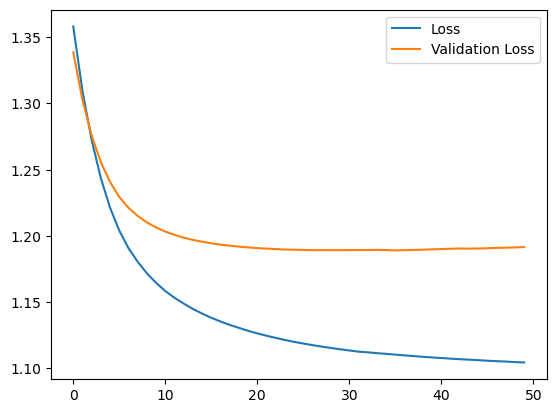

18/18 [==============================] - 0s 305us/step
Test accuracy: 0.43795620437956206
18/18 [==============================] - 0s 351us/step - loss: 1.0960
Test loss: 1.0959891080856323


In [33]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [34]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 2)
X_val shape (547, 2)
X_test shape (548, 2)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [35]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

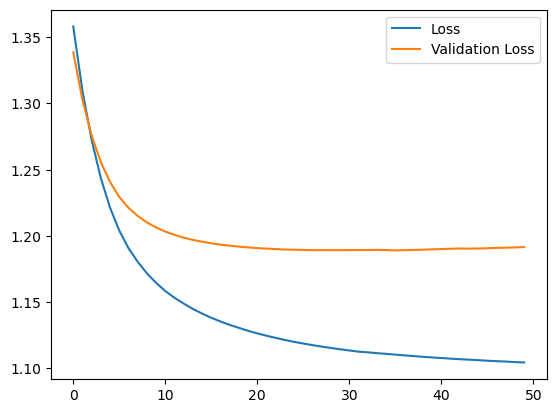

18/18 [==============================] - 0s 316us/step
Test accuracy: 0.43795620437956206
18/18 [==============================] - 0s 333us/step - loss: 1.0960
Test loss: 1.0959891080856323


In [36]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [37]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 2)
X_val shape (547, 2)
X_test shape (548, 2)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [38]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

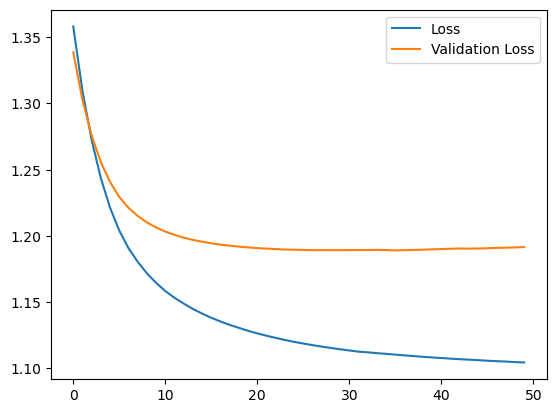

18/18 [==============================] - 0s 305us/step
Test accuracy: 0.43795620437956206
18/18 [==============================] - 0s 329us/step - loss: 1.0960
Test loss: 1.0959891080856323


In [39]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### CGAS Score

In [40]:
grp = "CGAS"

In [41]:
# pre-processing:

# CGAS-CGAS_Score: scale from 0 to 100
data_orig["CGAS-CGAS_Score"] = data_orig[["CGAS-CGAS_Score"]]/100
data_basic_impute["CGAS-CGAS_Score"] = data_basic_impute[["CGAS-CGAS_Score"]]/100
data_knn_impute["CGAS-CGAS_Score"] = data_knn_impute[["CGAS-CGAS_Score"]]/100

#### data_orig model

In [42]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1406, 1)
X_val shape (471, 1)
X_test shape (465, 1)
y_train shape (1406,)
y_val shape (471,)
y_test shape (465,)


In [43]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

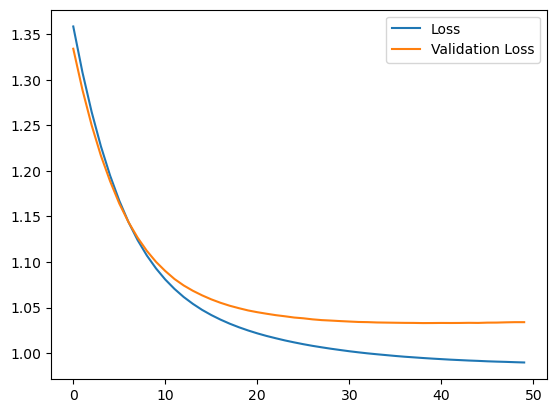

15/15 [==============================] - 0s 355us/step
Test accuracy: 0.5956989247311828
15/15 [==============================] - 0s 351us/step - loss: 0.9707
Test loss: 0.9706771373748779


In [44]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [45]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1406, 1)
X_val shape (471, 1)
X_test shape (465, 1)
y_train shape (1406,)
y_val shape (471,)
y_test shape (465,)


In [46]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

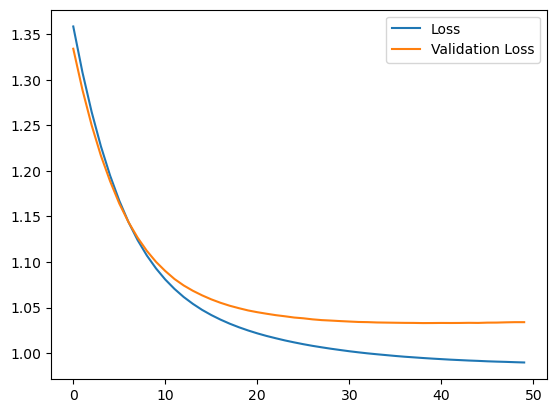

15/15 [==============================] - 0s 312us/step
Test accuracy: 0.5956989247311828
15/15 [==============================] - 0s 360us/step - loss: 0.9707
Test loss: 0.9706771373748779


In [47]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [48]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 1)
X_val shape (547, 1)
X_test shape (548, 1)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [49]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

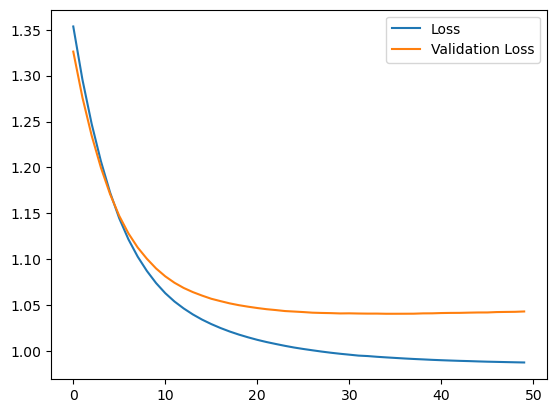

18/18 [==============================] - 0s 317us/step
Test accuracy: 0.6040145985401459
18/18 [==============================] - 0s 339us/step - loss: 0.9603
Test loss: 0.9603254795074463


In [50]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### Physical

In [51]:
grp = "Physical"

In [52]:
# pre-processing: all columns can be scaled using standard scaler

for col in col_groups["Physical"]:
    scaler = StandardScaler()
    scaler.fit(data_ref[[col]])
    data_orig[col] = scaler.transform(data_orig[[col]])
    data_basic_impute[col] = scaler.transform(data_basic_impute[[col]])
    data_knn_impute[col] = scaler.transform(data_knn_impute[[col]])

#### data_orig model

In [53]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1480, 4)
X_val shape (483, 4)
X_test shape (501, 4)
y_train shape (1480,)
y_val shape (483,)
y_test shape (501,)


In [54]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

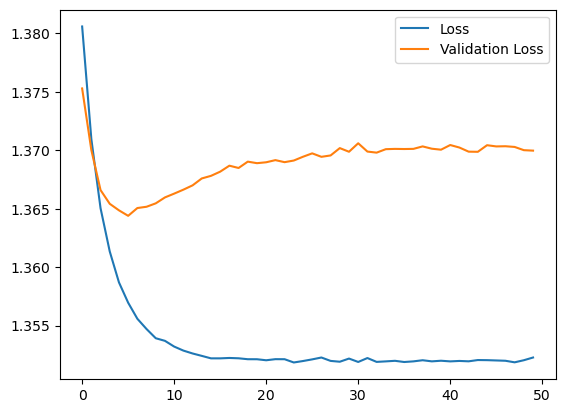

16/16 [==============================] - 0s 320us/step
Test accuracy: 0.4930139720558882
16/16 [==============================] - 0s 367us/step - loss: 1.3419
Test loss: 1.341915488243103


In [55]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [56]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1481, 4)
X_val shape (483, 4)
X_test shape (501, 4)
y_train shape (1481,)
y_val shape (483,)
y_test shape (501,)


In [57]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

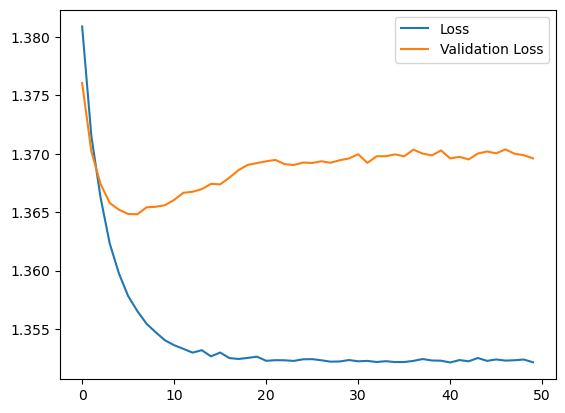

16/16 [==============================] - 0s 322us/step
Test accuracy: 0.49700598802395207
16/16 [==============================] - 0s 345us/step - loss: 1.3417
Test loss: 1.3416659832000732


In [58]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [59]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 4)
X_val shape (547, 4)
X_test shape (548, 4)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [60]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

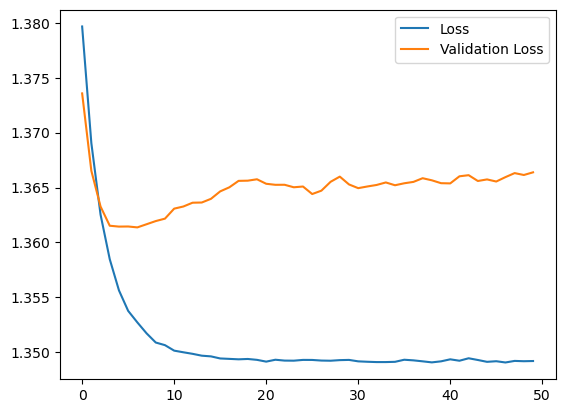

18/18 [==============================] - 0s 291us/step
Test accuracy: 0.4927007299270073
18/18 [==============================] - 0s 349us/step - loss: 1.3428
Test loss: 1.3427658081054688


In [61]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### Fitness Endurance

In [62]:
grp = "Fitness_Endurance"

In [63]:
# pre-processing (original data ONLY):

# Fitness_Endurance-Max_Stage: use standard scaler
scaler = StandardScaler()
scaler.fit(data_ref[["Fitness_Endurance-Max_Stage"]])
data_orig["Fitness_Endurance-Max_Stage"] = scaler.transform(data_orig[["Fitness_Endurance-Max_Stage"]])

# scale
scaler = StandardScaler()
scaler.fit(data_ref[["Fitness_Endurance-Time"]])
data_orig["Fitness_Endurance-Time"] = scaler.transform(data_orig[["Fitness_Endurance-Time"]])

# reset column group definition for fitness endurance
col_groups["Fitness_Endurance"] = ["Fitness_Endurance-Max_Stage","Fitness_Endurance-Time"]

#### data_orig model

In [64]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (443, 2)
X_val shape (133, 2)
X_test shape (151, 2)
y_train shape (443,)
y_val shape (133,)
y_test shape (151,)


In [65]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

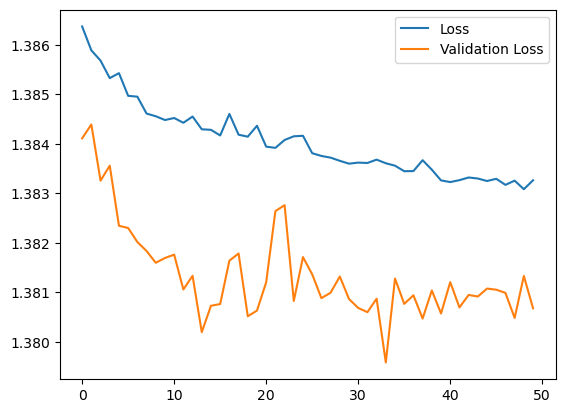

5/5 [==============================] - 0s 491us/step
Test accuracy: 0.33774834437086093
5/5 [==============================] - 0s 546us/step - loss: 1.3911
Test loss: 1.391130805015564


In [66]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

### FGC

In [67]:
grp = "FGC"

In [68]:
# pre-processing: all columns can be scaled using standard scaler

for col in col_groups["FGC"]:
    scaler = StandardScaler()
    scaler.fit(data_ref[[col]])
    data_orig[col] = scaler.transform(data_orig[[col]])
    data_basic_impute[col] = scaler.transform(data_basic_impute[[col]])
    data_knn_impute[col] = scaler.transform(data_knn_impute[[col]])

#### data_orig model

In [69]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1156, 5)
X_val shape (365, 5)
X_test shape (380, 5)
y_train shape (1156,)
y_val shape (365,)
y_test shape (380,)


In [70]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

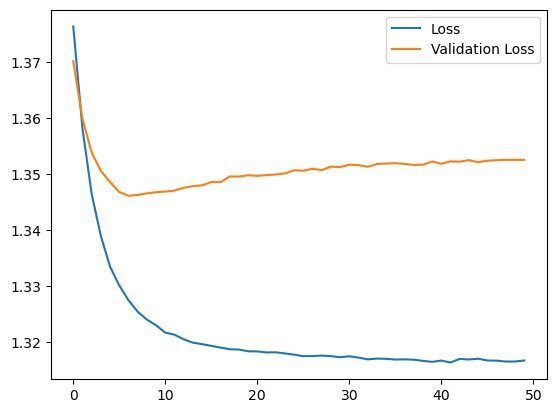

12/12 [==============================] - 0s 334us/step
Test accuracy: 0.55
12/12 [==============================] - 0s 365us/step - loss: 1.3295
Test loss: 1.3294986486434937


In [71]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [72]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1156, 5)
X_val shape (365, 5)
X_test shape (380, 5)
y_train shape (1156,)
y_val shape (365,)
y_test shape (380,)


In [73]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

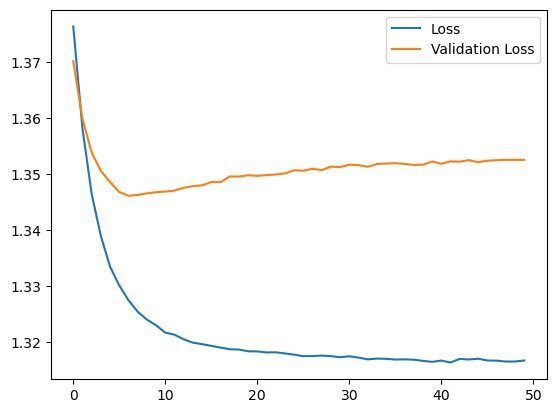

12/12 [==============================] - 0s 331us/step
Test accuracy: 0.55
12/12 [==============================] - 0s 362us/step - loss: 1.3295
Test loss: 1.3294986486434937


In [74]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [75]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 5)
X_val shape (547, 5)
X_test shape (548, 5)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [76]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

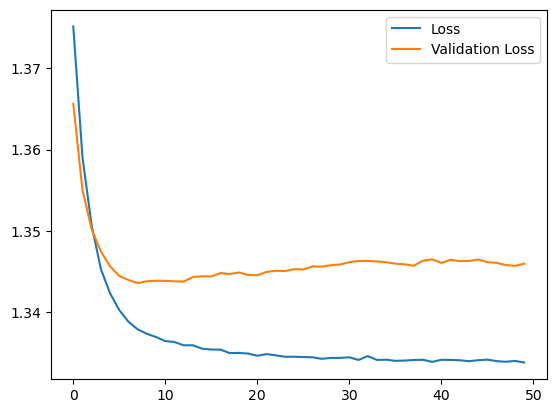

18/18 [==============================] - 0s 296us/step
Test accuracy: 0.5145985401459854
18/18 [==============================] - 0s 343us/step - loss: 1.3478
Test loss: 1.3478164672851562


In [77]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### BIA

In [78]:
grp = "BIA"

In [79]:
# pre-processing: all columns can be scaled using standard scaler

for col in col_groups["BIA"]:
    if col == "BIA-BIA_Fat":
        data_orig[col] = data_orig[[col]]/100
        data_basic_impute[col] = data_basic_impute[[col]]/100
        data_knn_impute[col] = data_knn_impute[[col]]/100
    elif 'categorical' in data_dict.Type[data_dict.Field == col].values[0]:
        # convert to one-hot
        dummies = pd.get_dummies(data_orig[col],prefix=col).astype(int)
        data_orig = pd.concat([data_orig, dummies], axis=1)
        data_orig.drop(labels=col,axis=1)
        dummies = pd.get_dummies(data_basic_impute[col],prefix=col).astype(int)
        data_basic_impute = pd.concat([data_basic_impute, dummies], axis=1)
        data_basic_impute.drop(labels=col,axis=1)
        dummies = pd.get_dummies(data_knn_impute[col],prefix=col).astype(int)
        data_knn_impute = pd.concat([data_knn_impute, dummies], axis=1)
        data_knn_impute.drop(labels=col,axis=1)
    else:
        scaler = StandardScaler()
        scaler.fit(data_ref[[col]])
        data_orig[col] = scaler.transform(data_orig[[col]])
        data_basic_impute[col] = scaler.transform(data_basic_impute[[col]])
        data_knn_impute[col] = scaler.transform(data_knn_impute[[col]])

# add one-hot column names to col_groups definition
col_groups["BIA"] = [col for col in data_orig.columns if "BIA" in col]

#### data_orig model

In [80]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1048, 24)
X_val shape (344, 24)
X_test shape (355, 24)
y_train shape (1048,)
y_val shape (344,)
y_test shape (355,)


In [81]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

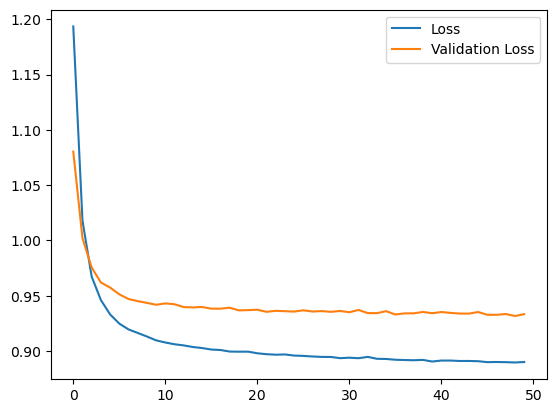

12/12 [==============================] - 0s 341us/step
Test accuracy: 0.5774647887323944
12/12 [==============================] - 0s 382us/step - loss: 0.9049
Test loss: 0.9049416780471802


In [82]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [83]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1048, 24)
X_val shape (344, 24)
X_test shape (355, 24)
y_train shape (1048,)
y_val shape (344,)
y_test shape (355,)


In [84]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

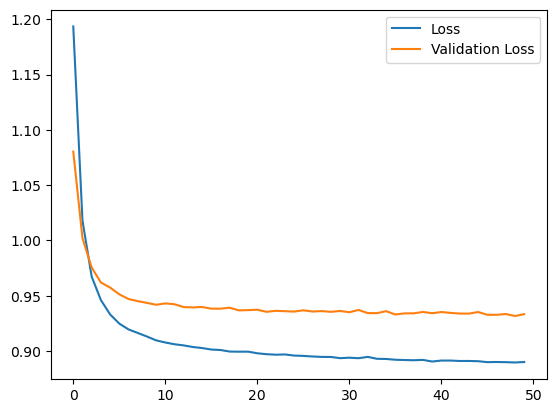

12/12 [==============================] - 0s 339us/step
Test accuracy: 0.5774647887323944
12/12 [==============================] - 0s 419us/step - loss: 0.9049
Test loss: 0.9049416780471802


In [85]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [86]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 24)
X_val shape (547, 24)
X_test shape (548, 24)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [87]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

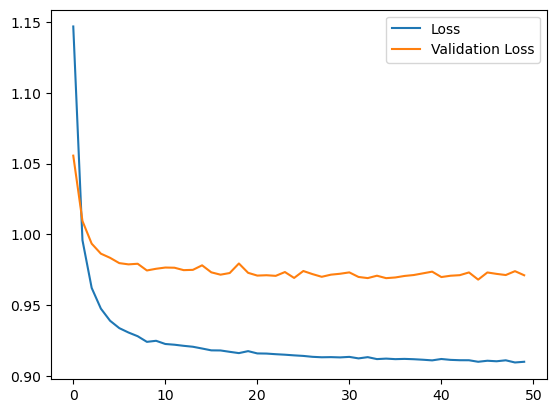

18/18 [==============================] - 0s 291us/step
Test accuracy: 0.5583941605839416
18/18 [==============================] - 0s 349us/step - loss: 0.9303
Test loss: 0.9303249716758728


In [88]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### PAQ

In [89]:
grp = "PAQ"

In [90]:
# pre-processing: all columns can be scaled using standard scaler

for col in col_groups["PAQ"]:
    scaler = StandardScaler()
    scaler.fit(data_ref[[col]])
    data_orig[col] = scaler.transform(data_orig[[col]])
    data_basic_impute[col] = scaler.transform(data_basic_impute[[col]])
    data_knn_impute[col] = scaler.transform(data_knn_impute[[col]])

#### data_orig model

In [91]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1074, 1)
X_val shape (353, 1)
X_test shape (375, 1)
y_train shape (1074,)
y_val shape (353,)
y_test shape (375,)


In [92]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

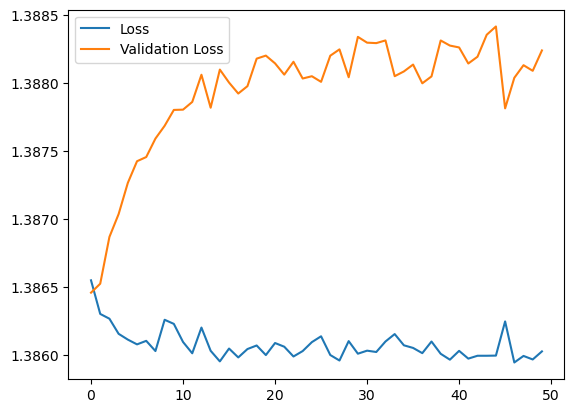

12/12 [==============================] - 0s 373us/step
Test accuracy: 0.43466666666666665
12/12 [==============================] - 0s 395us/step - loss: 1.3837
Test loss: 1.383686900138855


In [93]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [94]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1074, 1)
X_val shape (353, 1)
X_test shape (375, 1)
y_train shape (1074,)
y_val shape (353,)
y_test shape (375,)


In [95]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

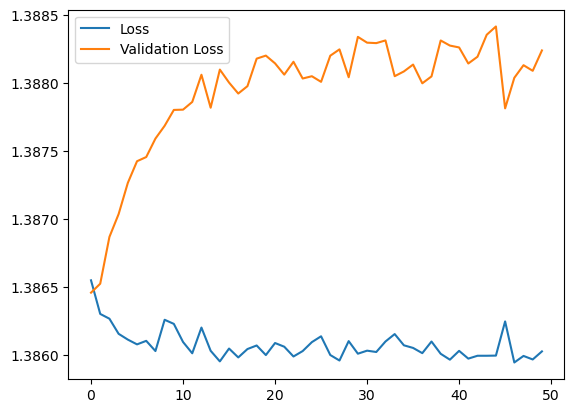

12/12 [==============================] - 0s 333us/step
Test accuracy: 0.43466666666666665
12/12 [==============================] - 0s 369us/step - loss: 1.3837
Test loss: 1.383686900138855


In [96]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [97]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 1)
X_val shape (547, 1)
X_test shape (548, 1)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [98]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

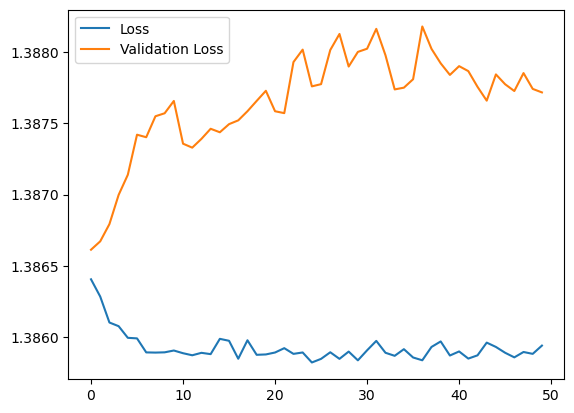

18/18 [==============================] - 0s 299us/step
Test accuracy: 0.43795620437956206
18/18 [==============================] - 0s 348us/step - loss: 1.3853
Test loss: 1.385266661643982


In [99]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### SDS

In [100]:
grp = "SDS"

In [101]:
# raw and T are redundant: use only raw

col_groups["SDS"] = ["SDS-SDS_Total_Raw"]

# CGAS-CGAS_Score: scale from 0 to 100
data_orig["SDS-SDS_Total_Raw"] = data_orig[["SDS-SDS_Total_Raw"]]/100
data_basic_impute["SDS-SDS_Total_Raw"] = data_basic_impute[["SDS-SDS_Total_Raw"]]/100
data_knn_impute["SDS-SDS_Total_Raw"] = data_knn_impute[["SDS-SDS_Total_Raw"]]/100

#### data_orig model

In [102]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1517, 1)
X_val shape (496, 1)
X_test shape (514, 1)
y_train shape (1517,)
y_val shape (496,)
y_test shape (514,)


In [103]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

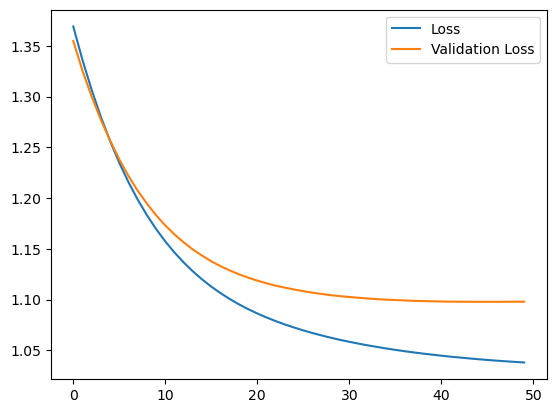

17/17 [==============================] - 0s 290us/step
Test accuracy: 0.6050583657587548
17/17 [==============================] - 0s 343us/step - loss: 1.0165
Test loss: 1.016506552696228


In [104]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [105]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1517, 1)
X_val shape (496, 1)
X_test shape (514, 1)
y_train shape (1517,)
y_val shape (496,)
y_test shape (514,)


In [106]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

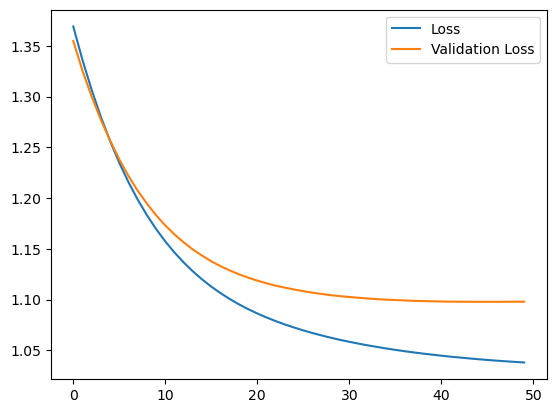

17/17 [==============================] - 0s 324us/step
Test accuracy: 0.6050583657587548
17/17 [==============================] - 0s 336us/step - loss: 1.0165
Test loss: 1.016506552696228


In [107]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [108]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 1)
X_val shape (547, 1)
X_test shape (548, 1)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [109]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

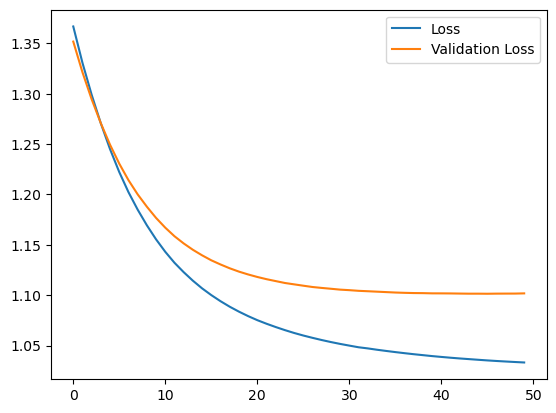

18/18 [==============================] - 0s 293us/step
Test accuracy: 0.6040145985401459
18/18 [==============================] - 0s 348us/step - loss: 1.0129
Test loss: 1.0128958225250244


In [110]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

### PreInt

In [111]:
grp = "PreInt"

In [112]:
# pre-processing: all columns can be scaled using standard scaler

for col in col_groups["PreInt"]:
    # convert to one-hot
    dummies = pd.get_dummies(data_orig[col],prefix=col).astype(int)
    data_orig = pd.concat([data_orig, dummies], axis=1)
    data_orig.drop(labels=col,axis=1)
    dummies = pd.get_dummies(data_basic_impute[col],prefix=col).astype(int)
    data_basic_impute = pd.concat([data_basic_impute, dummies], axis=1)
    data_basic_impute.drop(labels=col,axis=1)
    dummies = pd.get_dummies(data_knn_impute[col],prefix=col).astype(int)
    data_knn_impute = pd.concat([data_knn_impute, dummies], axis=1)
    data_knn_impute.drop(labels=col,axis=1)

# add one-hot column names to col_groups definition
col_groups["PreInt"] = [col for col in data_orig.columns if "PreInt" in col]

#### data_orig model

In [113]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig)
results.loc["n_orig",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1594, 5)
X_val shape (528, 5)
X_test shape (532, 5)
y_train shape (1594,)
y_val shape (528,)
y_test shape (532,)


In [114]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

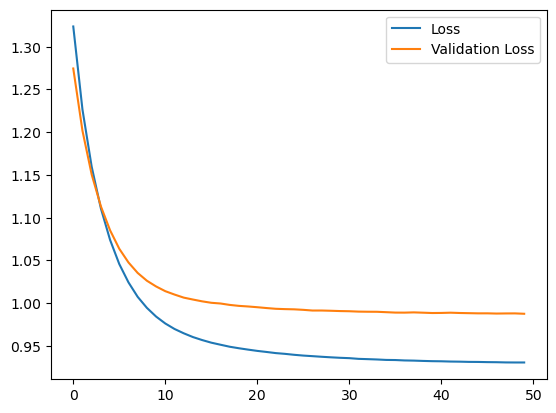

17/17 [==============================] - 0s 309us/step
Test accuracy: 0.6015037593984962
17/17 [==============================] - 0s 364us/step - loss: 0.9009
Test loss: 0.9009249210357666


In [115]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_orig",grp] = accuracy

#### data_basic_impute model

In [116]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_basic_impute)
results.loc["n_basic_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1594, 5)
X_val shape (528, 5)
X_test shape (532, 5)
y_train shape (1594,)
y_val shape (528,)
y_test shape (532,)


In [117]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

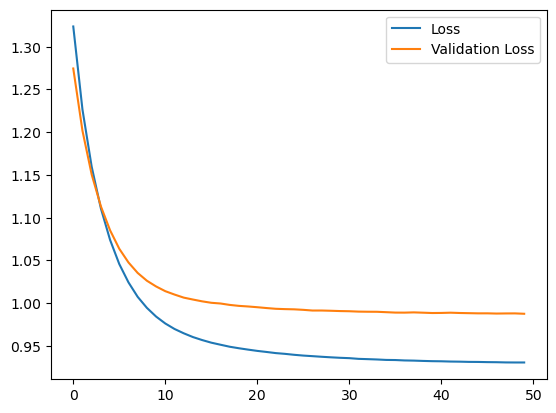

17/17 [==============================] - 0s 292us/step
Test accuracy: 0.6015037593984962
17/17 [==============================] - 0s 352us/step - loss: 0.9009
Test loss: 0.9009249210357666


In [118]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_basic_impute",grp] = accuracy

#### data_knn_impute model

In [119]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_knn_impute)
results.loc["n_knn_impute",grp] = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

X_train shape (1641, 5)
X_val shape (547, 5)
X_test shape (548, 5)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [120]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

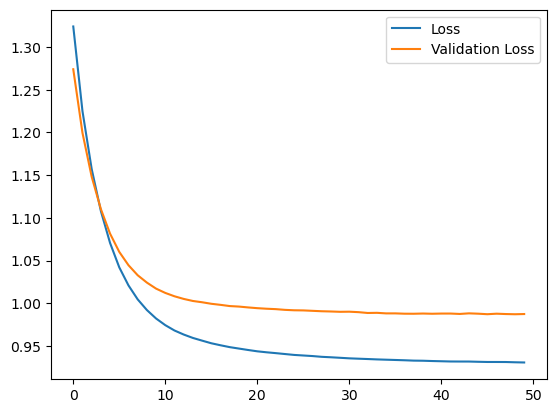

18/18 [==============================] - 0s 302us/step
Test accuracy: 0.6040145985401459
18/18 [==============================] - 0s 328us/step - loss: 0.9021
Test loss: 0.9020640254020691


In [121]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

results.loc["data_knn_impute",grp] = accuracy

# Final Results

In [122]:
results

,Basic_Demos,CGAS,Physical,Fitness_Endurance,FGC,BIA,PAQ,SDS,PreInt
n_orig,2736.000000,2342.000000,2464.000000,727.000000,1901.000000,1747.000000,1802.000000,2527.000000,2654.000000
data_orig,0.437956,0.595699,0.493014,0.337748,0.550000,0.577465,0.434667,0.605058,0.601504
n_basic_impute,2736.000000,2342.000000,2465.000000,NaN,1901.000000,1747.000000,1802.000000,2527.000000,2654.000000
data_basic_impute,0.437956,0.595699,0.497006,NaN,0.550000,0.577465,0.434667,0.605058,0.601504
n_knn_impute,2736.000000,2736.000000,2736.000000,NaN,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000
data_knn_impute,0.437956,0.604015,0.492701,NaN,0.514599,0.558394,0.437956,0.604015,0.604015


# Everything, imputed

(but no fitness endurance)

In [123]:
feat_cols = list(itertools.chain.from_iterable(col_groups.values()))
feat_cols = [col for col in feat_cols if "Fitness_Endurance" not in col]

In [124]:
# get_data
X_train, y_train, X_val, y_val, X_test, y_test = get_data(feat_cols, data_knn_impute)

X_train shape (1641, 43)
X_val shape (547, 43)
X_test shape (548, 43)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [125]:
# build model
model = build_multiclass_model(X_train)

# fit model
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

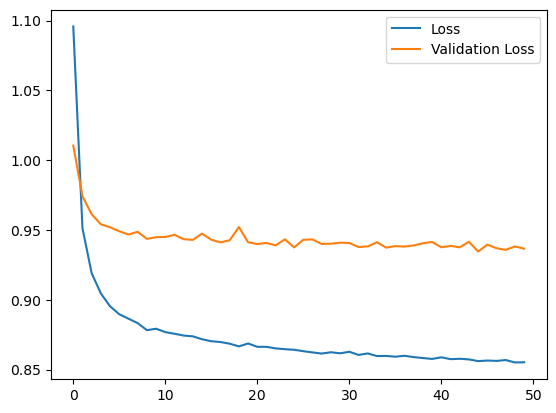

18/18 [==============================] - 0s 323us/step
Test accuracy: 0.5967153284671532
18/18 [==============================] - 0s 337us/step - loss: 0.9025
Test loss: 0.9024601578712463


In [126]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"Test accuracy: {accuracy}")
test_loss = model.evaluate(x=X_test, y=y_test)
print(f"Test loss: {test_loss}")

This is just barely the best model out of all of them.

# Combining Results from Mult Models

In [127]:
# train a model for each column group

models = {}

for grp in col_groups.keys():
    X_train, y_train, X_val, y_val, X_test, y_test = get_data(col_groups[grp], data_orig, verbose=False)

    checkpoint = ModelCheckpoint("model_{epoch:02d}.h5", save_weights_only=True, save_freq=1)

    model = build_multiclass_model(X_train)

    # fit model
    history = model.fit(
        x = X_train,
        y = y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=10,
        verbose=0,
        callbacks=[checkpoint]
    )

    # get number of epochs where val loss was lowest
    use_me = np.argmin(history.history['val_loss']) + 1
    print(f"Best {grp} num epochs:",use_me)
    model.load_weights(f"model_{use_me:02d}.h5")

    models[grp] = model        
    

Best Basic_Demos num epochs: 36
Best CGAS num epochs: 39
Best Physical num epochs: 6
Best Fitness_Endurance num epochs: 34
Best FGC num epochs: 7
Best BIA num epochs: 49
Best PAQ num epochs: 1
Best SDS num epochs: 47
Best PreInt num epochs: 50


Get full set of train/val/test data:

In [128]:
X_train, y_train, X_val, y_val, X_test, y_test = get_data(None, data_orig)

X_train shape (1641, 63)
X_val shape (547, 63)
X_test shape (548, 63)
y_train shape (1641,)
y_val shape (547,)
y_test shape (548,)


In [129]:
X_train_vec = np.zeros((X_train.shape[0],len(col_groups),4))
X_val_vec = np.zeros((X_val.shape[0],len(col_groups),4))
X_test_vec = np.zeros((X_test.shape[0],len(col_groups),4))

In [130]:
for idx,grp in enumerate(col_groups):

    # training data
    data = X_train.loc[:,col_groups[grp]]
    data.reset_index(inplace=True, drop=True)
    data.dropna()
    preds = models[grp].predict(data)
    preds = np.log(preds)
    preds -= np.mean(preds, axis=1).reshape((-1,1))
    preds = np.tanh(preds)
    preds = np.nan_to_num(preds)
    X_train_vec[data.index, idx, :] = preds

    # validation data
    data = X_val.loc[:,col_groups[grp]]
    data.reset_index(inplace=True, drop=True)
    data.dropna()
    preds = models[grp].predict(data)
    preds = np.log(preds)
    preds -= np.mean(preds, axis=1).reshape((-1,1))
    preds = np.tanh(preds)
    preds = np.nan_to_num(preds)
    X_val_vec[data.index, idx, :] = preds

    # testing data
    data = X_test.loc[:,col_groups[grp]]
    data.reset_index(inplace=True, drop=True)
    data.dropna()
    preds = models[grp].predict(data)
    preds = np.log(preds)
    preds -= np.mean(preds, axis=1).reshape((-1,1))
    preds = np.tanh(preds)
    preds = np.nan_to_num(preds)
    X_test_vec[data.index, idx, :] = preds

18/18 [==============================] - 0s 308us/step


Simple test: all tests equally weighted.

In [131]:
X_test_combined = np.sum(X_test_vec, axis=1)
test_preds_labels = np.argmax(X_test_combined, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.5912408759124088


Other method: learn optimal weights of components.

In [132]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=4,
    input_shape = (36,),
    use_bias=False,
    activation='softmax',
    kernel_initializer=tf.ones_initializer,
))
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# fit model
history = model.fit(
    x = X_train_vec,
    y = y_train,
    validation_data=(X_val_vec, y_val),
    epochs=50,
    batch_size=10,
    verbose=1,
)

Epoch 1/50
165/165 [==============================] - 0s 720us/step - loss: 1.1175 - val_loss: 1.0372
Epoch 2/50
165/165 [==============================] - 0s 449us/step - loss: 0.9817 - val_loss: 1.0052
Epoch 3/50
165/165 [==============================] - 0s 420us/step - loss: 0.9495 - val_loss: 0.9956
Epoch 4/50
165/165 [==============================] - 0s 424us/step - loss: 0.9337 - val_loss: 0.9880
Epoch 5/50
165/165 [==============================] - 0s 422us/step - loss: 0.9234 - val_loss: 0.9829
Epoch 6/50
165/165 [==============================] - 0s 424us/step - loss: 0.9166 - val_loss: 0.9849
Epoch 7/50
165/165 [==============================] - 0s 422us/step - loss: 0.9118 - val_loss: 0.9800
Epoch 8/50
165/165 [==============================] - 0s 419us/step - loss: 0.9075 - val_loss: 0.9811
Epoch 9/50
165/165 [==============================] - 0s 419us/step - loss: 0.9041 - val_loss: 0.9755
Epoch 10/50
165/165 [==============================] - 0s 421us/step - loss: 0.901

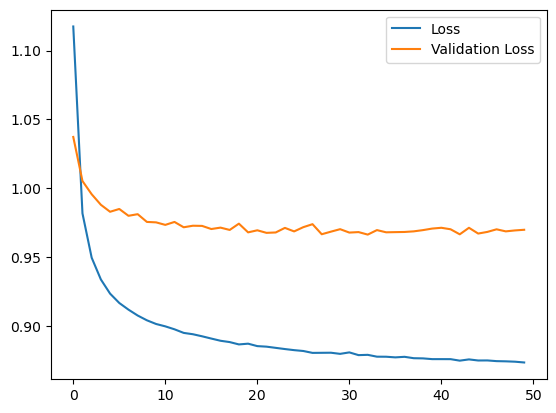

In [133]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(50),history.history['loss'],label="Loss")
ax.plot(np.arange(50),history.history['val_loss'],label="Validation Loss")
ax.legend()
plt.show()

In [134]:
test_preds = model.predict(X_test_vec)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print("Test accuracy:", accuracy)

18/18 [==============================] - 0s 312us/step
Test accuracy: 0.5912408759124088


<BarContainer object of 56 artists>

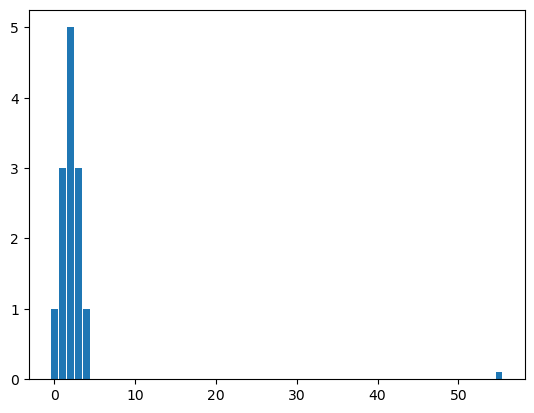

In [138]:
plt.bar([i for i in range(56)],[1,3,5,3,1]+[0 for _ in range(50)]+[0.1])